[![image-1.png](https://i.postimg.cc/Vk3VrVXM/image-1.png)](https://postimg.cc/v4tzCXqH)

<div style="padding:15px 20px 20px 20px;
            color:#004346;
            font-size:40px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">
<p style="font-weight: bold; text-align: center;">Прогнозирование оттока клиентов</p>

</div>

<div style="padding:0px 40px 30px;
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:450;">
    
__Заказчик:__ Оператор связи «ТелеДом».
    
__Описание задачи:__ Для борьбы с оттоком клиентов, сотрудники компании будут предлагать промокоды и специальные условия тем абонентам, которые имеют намерение прекратить пользоваться услугами связи. Это позволит заранее выявлять пользователей, склонных к расторжению договора.

__Постановка задачи:__ Разработать модель для прогнозирования вероятности расторжения договора абонентом.
    
__Оценка качества модели:__ Метрики ROC-AUC, значение должно быть не менее 0.85. 

__Описание услуг компании:__ Оператор предоставляет два основных типа услуг:
    
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение бывает двух типов: через телефонную линию DSL (англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (англ. fiber optic).
    
Также абонентам доступен ряд дополнительных услуг:
    
- Интернет-безопасность: антивирус (Device Protection) и блокировка опасных сайтов (Online Security);
- Выделенная линия технической поддержки (Tech Support);
- Облачное хранилище файлов для резервного копирования данных (Online Backup);
- Стриминговое телевидение (Streaming TV) и каталог фильмов (Streaming Movies).
    
За услуги клиенты могут платить ежемесячно или раз в 1–2 года. Доступны различные способы расчёта и возможность получить электронный чек.
    
__Описание данных:__ персональные данные о некоторых клиентах, информация об их тарифах и услугах.
 
Данные хранятся в базе данных PostgreSQL. Она состоит из нескольких [таблиц](https://github.com/Denis-Mukhanov/client-churn-prediction/blob/main/data/data%20description.pdf):
    
- `contract` — информация о договорах;
- `personal` — персональные данные клиентов;
- `internet` — информация об интернет-услугах;
- `phone` — информация об услугах телефонии.


</div>    

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

# Используемые библиотеки

</div>

In [1]:
from rich.console import Console
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

import phik
import psycopg2
import sqlalchemy
from sqlalchemy import create_engine

# константы
RANDOM_SEED = 181023

# настройки блокнота
pd.options.display.max_colwidth = 500
random.seed(RANDOM_SEED)

# экземпляр консоли
console = Console()

## Подключение к базе данных

In [2]:
# конфигурация для подключения к базе данных
db_config = {
    'user': 'praktikum_student',# имя пользователя,
    'pwd': 'Sdf4$2;d-d30pp',# пароль,
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432,# порт подключения,
    'db': 'data-science-final'# название базы данных,
} 

# создание подключения к базе данных
connection = psycopg2.connect(
    user=db_config['user'],
    password=db_config['pwd'],
    host=db_config['host'],
    port=db_config['port'],
    database=db_config['db']
)

# создаем курсора для выполнения запросов
cursor = connection.cursor()

__функция для выполнения запросов__

In [3]:
# функция для выполнения запросов
def request(query):
    try:
        cursor.execute(query)
        result = cursor.fetchall()
        result_df = pd.DataFrame(result, columns=[desc[0] for desc in cursor.description])
        return result_df
    except Exception as e:
        print(f'Error: {e}')
        connection.rollback()  # откат транзакции, для избежания блокировки

In [4]:
# тестовый запрос
query = '''
SELECT *
FROM telecom.contract
LIMIT 1;
'''
display(request(query))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,None


<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

# Первичное исследование таблиц базы данных

</div>

__Проверим таблицы на наличие данных__

In [5]:
# список всех таблиц
tables = ['contract', 'personal', 'internet', 'phone']

In [6]:
for table in tables:
    query = f'SELECT COUNT(*) FROM telecom.{table};'
    contract_count = request(query).iloc[0][0]
    print(f'Количество записей в таблице {table}: {contract_count}')


Количество записей в таблице contract: 7043
Количество записей в таблице personal: 7043
Количество записей в таблице internet: 5518
Количество записей в таблице phone: 6362


>Все четыре таблицы доступны и содержат данные, 
>Количество записей  в таблицах "contract" и "personal" одинаковы, что соответствует условию задачи,
>Таблицы "internet" и "phone" имеют различное количество записей, что может быть связани, что не все пользователь пользуются одновременно интернет и услугами телефонии,
>Количество записей невилико и мы можем выгрузить таблицы, для дальнейшего анализа.

## Выгрузка таблиц базы данных

In [7]:
# информация о договорах
contract_df = request('SELECT * FROM telecom.contract;')
console.print('[bold]Датасет с информацией о договорах[/bold]')
display(contract_df.head(2))
display(contract_df.info())

# персональные данные клиентов
personal_df = request('SELECT * FROM telecom.personal;')
console.print('[bold]Датасет с информацией о персональных данных клиентов[/bold]')
display(personal_df.head(2))
display(personal_df.info())

# информация об интернет-услугах
internet_df = request('SELECT * FROM telecom.internet;')
internet_df.columns = list(internet_df.iloc[0].values)
internet_df = internet_df.drop(0, axis=0)
console.print('[bold]Датасет с информацией об интернет-услугах[/bold]')
display(internet_df.head(2))
display(internet_df.info())

# информация об услугах телефонии
phone_df = request('SELECT * FROM telecom.phone;')
phone_df.columns = list(phone_df.iloc[0].values)
phone_df = phone_df.drop(0, axis=0)
console.print('[bold]Датасет с информацией об услугах телефонии[/bold]')
display(phone_df.head(2))
display(phone_df.info())

Датасет с информацией о договорах

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,None
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   BeginDate         7043 non-null   object
 2   EndDate           1869 non-null   object
 3   Type              7043 non-null   object
 4   PaperlessBilling  7043 non-null   object
 5   PaymentMethod     7043 non-null   object
 6   MonthlyCharges    7043 non-null   object
 7   TotalCharges      7032 non-null   object
dtypes: object(8)
memory usage: 440.3+ KB


None

Датасет с информацией о персональных данных клиентов

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

Датасет с информацией об интернет-услугах

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 1 to 5517
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

Датасет с информацией об услугах телефонии

,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 1 to 6361
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

In [8]:
# список датасетов
list_df = [contract_df, personal_df, internet_df, phone_df]

>Регистр названий признаков не соответствует стандарту.

__Перееименуем признаки__

In [9]:
new_column_names = {
    'customerID': 'customer_id',               #ID абонента
    'BeginDate': 'begin_date',                 #дата начала действия договора
    'EndDate': 'end_date',                     #дата окончания действия договора
    'Type': 'type',                            #тип оплаты: раз в год-два или ежемесячно
    'PaperlessBilling': 'paperless_billing',   #электронный расчётный лист
    'PaymentMethod': 'payment_method',         #тип платежа
    'MonthlyCharges': 'monthly_charges',       #расходы за месяц
    'TotalCharges': 'total_charges',           #общие расходы абонента
    'SeniorCitizen': 'senior_citizen',         #является ли абонент пенсионером
    'Partner': 'partner',                      #есть ли у абонента супруг или супруга
    'Dependents': 'dependents',                #есть ли у абонента дети
    'InternetService': 'internet_service',     #тип подключения
    'OnlineSecurity': 'online_security',       #блокировка опасных сайтов
    'OnlineBackup': 'online_backup',           #облачное хранилище файлов для резервного копирования данных
    'DeviceProtection': 'device_protection',   #антивирус
    'TechSupport': 'tech_support',             #выделенная линия технической поддержки
    'StreamingTV': 'streaming_tv',             #стриминговое телевидение
    'StreamingMovies': 'streaming_movies',     #каталог фильмо
    'MultipleLines': 'multiplelines'           #подключение телефона к нескольким линиям одновременно
}

In [10]:
contract_df = contract_df.rename(columns=new_column_names).copy()
display(contract_df.head(1))
personal_df = personal_df.rename(columns=new_column_names).copy()
display(personal_df.head(1))
internet_df = internet_df.rename(columns=new_column_names).copy()
display(internet_df.head(1))
phone_df = phone_df.rename(columns=new_column_names).copy()
display(phone_df.head(1))

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,None


,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No


,customer_id,multiplelines
1,5575-GNVDE,No


> Признаки успешно переименованы, с учетом PEP8

__Проверим дубликатов в данных__

In [11]:
print(f'Общее количество дубликатов в данных: {sum(df.duplicated().sum() for df in list_df)}')

Общее количество дубликатов в данных: 0


>Успешно выгрены таблицы из базы данных;
>
>Названий признаков откорректированы в соответствии стандарту PEP8;
>
>Полные дубликаты в данных отсутствуют

## Анализ информациии о договорах: `contract_df`
### Общая информация

In [12]:
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        7043 non-null   object
 1   begin_date         7043 non-null   object
 2   end_date           1869 non-null   object
 3   type               7043 non-null   object
 4   paperless_billing  7043 non-null   object
 5   payment_method     7043 non-null   object
 6   monthly_charges    7043 non-null   object
 7   total_charges      7032 non-null   object
dtypes: object(8)
memory usage: 440.3+ KB


__Обработка типов данных__

Изменим типы данных в датасете:

- `begin_date`, `end_date` -  datetime
- `monthly_charges`, `total_charges` - float

In [13]:
# преобразование признаков begin_date и end_date в тип данных datetime
contract_df['begin_date'] = pd.to_datetime(contract_df['begin_date'])
contract_df['end_date'] = pd.to_datetime(contract_df['end_date'])

# преобразование признаков monthly_charges и total_charges в тип данных float
contract_df['monthly_charges'] = contract_df['monthly_charges'].astype(float)
contract_df['total_charges'] = contract_df['total_charges'].astype(float)

### Пропуcки в данных

In [14]:
display(contract_df.isna().mean())

customer_id          0.000000
begin_date           0.000000
end_date             0.734630
type                 0.000000
paperless_billing    0.000000
payment_method       0.000000
monthly_charges      0.000000
total_charges        0.001562
dtype: float64

__Пропуcки в признаке `total_charges`__

In [15]:
contract_df[contract_df['total_charges'].isna()].head(5)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN
3,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN
6,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,NaN
7,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,NaN


Можно увидеть, что дата заключения договора 1 февраля 2020 года. Как раз та дата, когда у нас была выгрузка данных. Следовательно данных ещё о платеже нет, либо не успели загрузить в базу данных. Так как подобных записей крайне мало и они могут внести искажение в анализ, следует их удалить.

In [16]:
contract_df = contract_df[~contract_df['total_charges'].isna()].copy()

__Пропуcки в признаке `end_date`__

При отсутствии даты окончания действия договора, на момент выгрузки данных, клиент считатся активным. Из данного признака получим целевой признак оттока клиентов, а пропуски заменим датой выгрузки данных.

In [17]:
# пелучение целевой переменной
contract_df['churn'] = ~contract_df['end_date'].isna()*1

Признак `churn` содержит значения:
- 1 факт ухода клиента
- 0 клиент продолжает пользоваться услугами компании

In [18]:
# замена пропусков в столбце end_date на "2020-02-01"
contract_df['end_date'].fillna("2020-02-01", inplace=True)

### Анализ временных признаков

In [19]:
# получим минимальную и максимальную даты в столбце begin_date
min_begin_date = contract_df['begin_date'].min()
max_begin_date = contract_df['begin_date'].max()

# получим минимальную и максимальную даты в столбце end_date
min_end_date = contract_df['end_date'].min()
max_end_date = contract_df['end_date'].max()

# вывод полученных значений
print(f'Минимальная дата в begin_date: {min_begin_date}')
print(f'Максимальная дата в begin_date: {max_begin_date}')
print(f'Минимальная дата в end_date: {min_end_date}')
print(f'Максимальная дата в end_date: {max_end_date}')

Минимальная дата в begin_date: 2018-04-17 00:00:00
Максимальная дата в begin_date: 2020-01-29 00:00:00
Минимальная дата в end_date: 2019-10-01 00:00:00
Максимальная дата в end_date: 2020-02-01 00:00:00


>Аномальных значений в данных признаках не наблюдается.
>
>Сами даты из-за большой вариативности не несут полезную нагрузку при построении моделей, но можем получить дополнительные признаки:
- продолжительность действия контракта, отразит насколько долго клиент пользуется услугами, выразим значение в месяцах.

In [20]:
contract_df['tenure_months'] = (contract_df['end_date'] - contract_df['begin_date']).dt.days // 30

#### Зависимость факта ухода клиентов от месяца и года

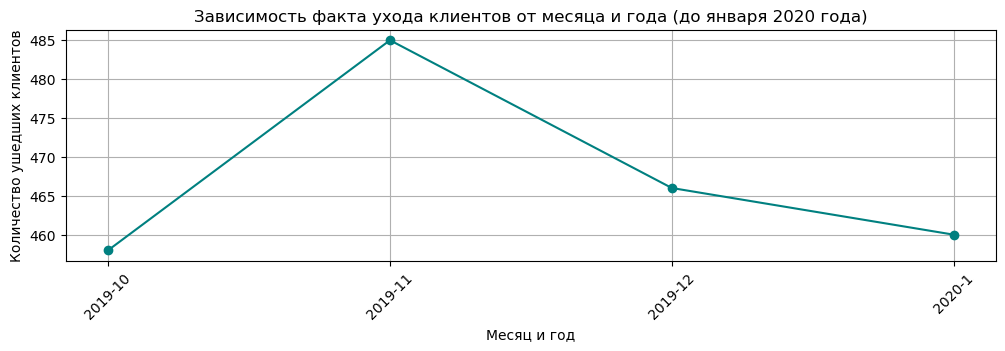

In [30]:
data_info = contract_df.copy()
data_info['churn_month'] = data_info['end_date'].dt.month
data_info['churn_year'] = data_info['end_date'].dt.year

# ограничиваем данные до января 2020 года
data_info = data_info[(data_info['churn_year'] < 2020) | ((data_info['churn_year'] == 2020) & (data_info['churn_month'] == 1))]

# группируем данные по месяцам и годам и подсчитываем количество ушедших клиентов
churn_summary = data_info.groupby(['churn_year', 'churn_month'])['churn'].sum().reset_index()

# визуализируем зависимость месяца и факта ухода клиентов
plt.figure(figsize=(12, 3))
plt.plot(churn_summary['churn_year'].astype(str) + '-' + churn_summary['churn_month'].astype(str), churn_summary['churn'], marker='o', color='teal')
plt.title('Зависимость факта ухода клиентов от месяца и года (до января 2020 года)')
plt.xlabel('Месяц и год')
plt.ylabel('Количество ушедших клиентов')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Зависимость ухода клиентов от месяца и года, исходя из графика, слабая, этот признак не подходит для дальнейшего анализа

### Анализ категориальных признаков

In [23]:
display(contract_df.describe(include=[object]))

,customer_id,type,paperless_billing,payment_method
count,7032,7032,7032,7032
unique,7032,3,2,4
top,3668-QPYBK,Month-to-month,Yes,Electronic check
freq,1,3875,4168,2365


__Посмотрим уникальные значения в категориальных признаках и их распределения:__

In [24]:
# функция для вывода уникальных значений и распределения
def uniq_val(df, sign):
    print(f'Уникальные значения признака {sign} в данных:\n{df[sign].unique()}')
    display(df[sign].value_counts())

In [25]:
uniq_val(contract_df, 'type')
uniq_val(contract_df, 'paperless_billing')
uniq_val(contract_df, 'payment_method')

Уникальные значения признака type в данных:
['Month-to-month' 'Two year' 'One year']


Month-to-month    3875
Two year          1685
One year          1472
Name: type, dtype: int64

Уникальные значения признака paperless_billing в данных:
['Yes' 'No']


Yes    4168
No     2864
Name: paperless_billing, dtype: int64

Уникальные значения признака payment_method в данных:
['Mailed check' 'Electronic check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)    1542
Credit card (automatic)      1521
Name: payment_method, dtype: int64

Исходя из значений и рапределений данных:
- В признаках нет групп с малым количеством данных, требующих объединение.
- Большинство людей предпочитают ежемесячные платежи, электронные рассчетные листы.

### Анализ числовых признаков

In [27]:
# статистика для crowd_annotat
console.print('[bold]Статистика для contract_df:[/bold]')
print(contract_df.describe())

Статистика для contract_df:

       monthly_charges  total_charges        churn  tenure_months
count      7032.000000    7032.000000  7032.000000    7032.000000
mean         64.798208    2283.300441     0.265785       9.446815
std          30.085974    2266.771362     0.441782       2.785462
min          18.250000      18.800000     0.000000       0.000000
25%          35.587500     401.450000     0.000000       8.000000
50%          70.350000    1397.475000     0.000000       9.000000
75%          89.862500    3794.737500     1.000000      11.000000
max         118.750000    8684.800000     1.000000      19.000000


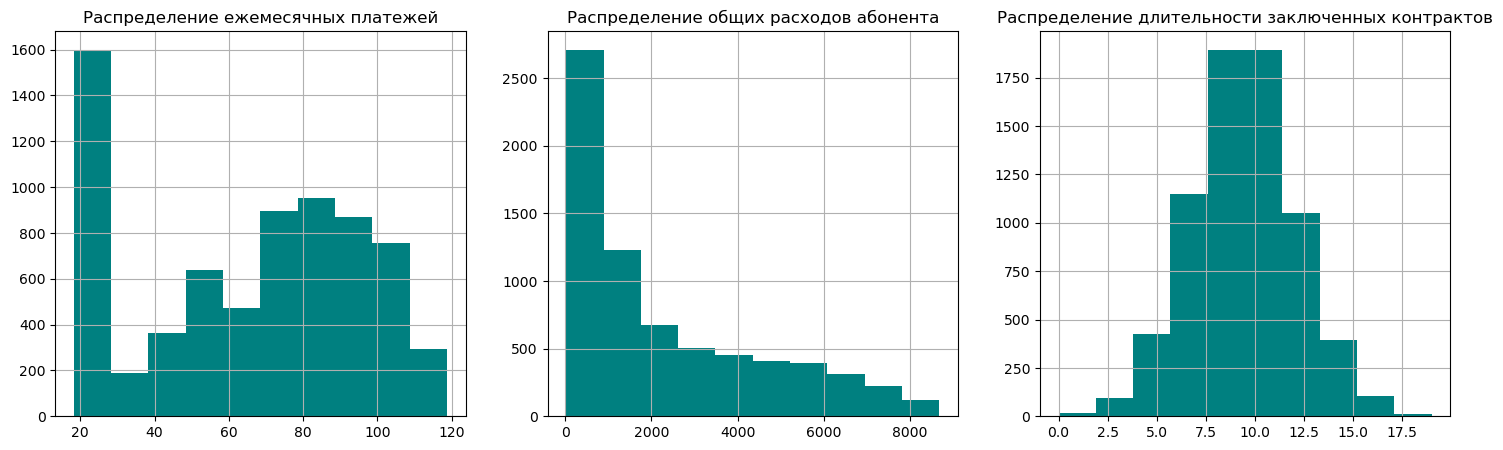

In [29]:
# визуализация данных
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

contract_df['monthly_charges'].hist(ax=axes[0], color='teal')
axes[0].set_title("Распределение ежемесячных платежей")

contract_df['total_charges'].hist(ax=axes[1], color='teal')
axes[1].set_title("Распределение общих расходов абонента")

contract_df['tenure_months'].hist(ax=axes[2], color='teal')
axes[2].set_title("Распределение длительности заключенных контрактов")

plt.show()

Исходя из общей статистики числовых данных и их визуализации, можно сделать вывод, что в данных отсутствуют явные аномалии, экстримально большие или маленькие значения.

### Итоговый датасет с информацией о договорах

In [32]:
contract_df = contract_df.drop(['begin_date', 'end_date'], axis=1)

In [33]:
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 2 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7032 non-null   object 
 1   type               7032 non-null   object 
 2   paperless_billing  7032 non-null   object 
 3   payment_method     7032 non-null   object 
 4   monthly_charges    7032 non-null   float64
 5   total_charges      7032 non-null   float64
 6   churn              7032 non-null   int64  
 7   tenure_months      7032 non-null   int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 494.4+ KB


>Проведен анализ данных с информацией о договорах;
>
>Обработаны пропуски и аномалии;
>
>Добавлен целевой и признак отражающий как давно челорвек, является абонентом компании.

## Анализ информациии о персональных данных клиентов: `personal_df`
### Общая информация

In [35]:
display(personal_df.head(2))
display(personal_df.info())

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

__Проверим пропуски в данных:__

In [39]:
print(f'Общее количество пропусков в данных: {sum(personal_df.isna().sum())}')

Общее количество пропусков в данных: 0


### Визуализация данных

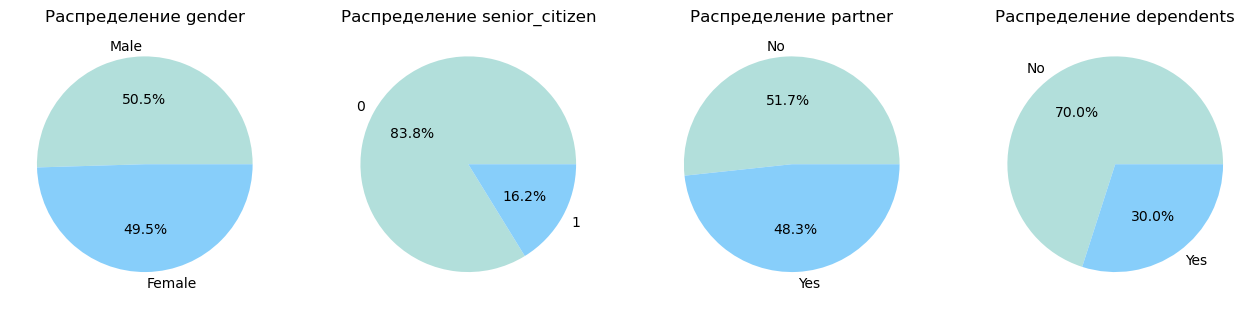

In [52]:
binary_features = ['gender', 'senior_citizen', 'partner', 'dependents']
# палитра
pastel_colors = ['#B2DFDB', 'lightskyblue']

plt.figure(figsize=(16, 4))

# визуализация
for i, feature in enumerate(binary_features):
    plt.subplot(1, 4, i + 1)  
    plt.title(f'Распределение {feature}')
    
    personal_df[feature].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=pastel_colors)
    plt.ylabel('') 


В данных пропуски отсутствуют.

Из распределения данных можно понять:

- Пол (gender): В датасете клиентов примерно одинаковое количество мужчин и женщин, с небольшим преимуществом мужчин (3555 мужчин и 3488 женщин). Это говорит о том, что половая принадлежность клиентов достаточно равномерно распределена.
- Является ли клиент пенсионером (senior_citizen): Большинство клиентов в датасете (5901 человек) не являются пенсионерами, в то время как 1142 клиента являются пенсионерами.
- Наличие супруга или супруги (partner): В датасете 3641 клиентов не имеют супруга или супруги, в то время как 3402 клиента имеют супруга или супругу. Распределение близко к равномерному, что может указывать на разнообразие семейных структур среди клиентов.
- Наличие детей (dependents):Большинство клиентов (4933 человека) не имеют детей, в то время как 2110 клиентов имеют детей. Это может быть важным фактором при анализе поведения клиентов и их решениях о продолжении использования услуг.

Эти данные предоставляют нам информацию о демографических характеристиках клиентов и их семейном статусе. Данные выводы могут быть полезными для дальнейшего анализа и разработки стратегии по удержанию клиентов, учитывая их особенности и потребности.

## Анализ информациии об интернет-услугах: `internet_df`
### Общая информация

In [53]:
display(internet_df.head(2))
display(internet_df.info())

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 1 to 5517
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

__Проверим пропуски в данных:__

In [61]:
print(f'Общее количество пропусков в данных: {sum(internet_df.isna().sum())}')

Общее количество пропусков в данных: 0


### Визуализация данных

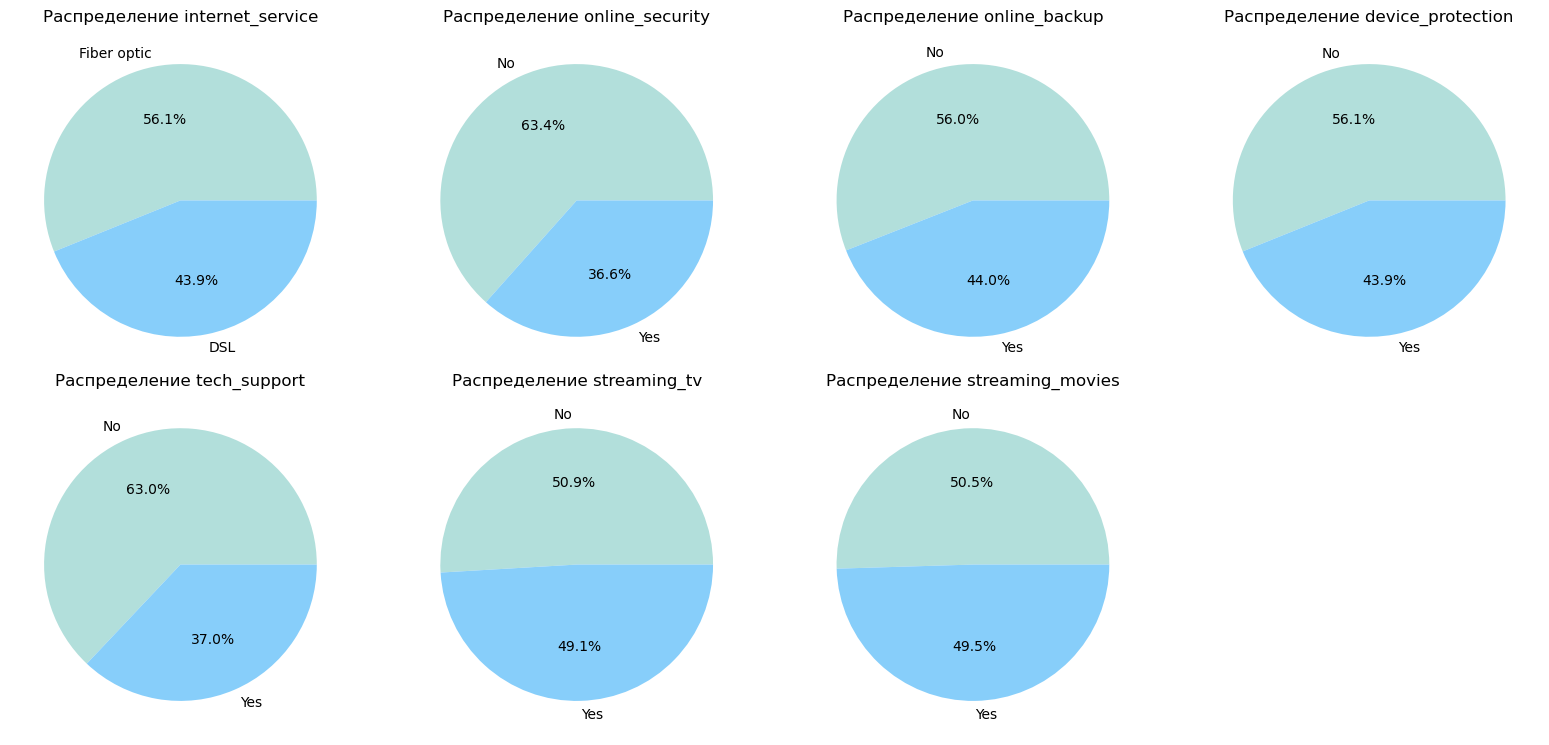

In [66]:
features = ['internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
# палитра
pastel_colors = ['#B2DFDB', 'lightskyblue']

plt.figure(figsize=(16, 8))
for i, feature in enumerate(features):
    if i < 4:
        plt.subplot(2, 4, i + 1)  # 2x4 сетка графиков
        plt.title(f'Распределение {feature}')
    else:
        plt.subplot(2, 4, i + 1)  # 2x4 сетка графиков
        plt.title(f'Распределение {feature}')
    
    pie_data = internet_df[feature].value_counts()
    pie_labels = pie_data.index
    pie_colors = pastel_colors[:len(pie_labels)]
    pie_data.plot(kind='pie', autopct='%1.1f%%', colors=pie_colors, labels=pie_labels)
    plt.ylabel('')
    plt.xlabel('')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


В данных пропуски отсутствуют.

Из визуализации данных можно понять, что все признаки распределены равномерно.

Следует отметить, что колличество клиентов, которые пользуются интернет-услугами меньше чем общее количество пользователей.

## Анализ информациии об услугах телефонии: `phone_df`
### Общая информация

In [62]:
display(phone_df.head(2))
display(phone_df.info())

,customer_id,multiplelines
1,5575-GNVDE,No
2,3668-QPYBK,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 1 to 6361
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customer_id    6361 non-null   object
 1   multiplelines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

__Проверим пропуски в данных:__

In [63]:
print(f'Общее количество пропусков в данных: {sum(internet_df.isna().sum())}')

Общее количество пропусков в данных: 0


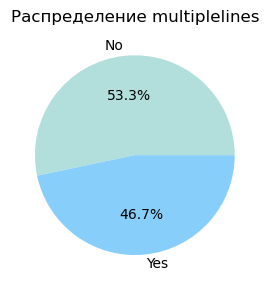

In [67]:
features = ['multiplelines']
# палитра
pastel_colors = ['#B2DFDB', 'lightskyblue']

plt.figure(figsize=(16, 3))

for i, feature in enumerate(binary_features):
    plt.subplot(1, 4, i + 1)
    plt.title(f'Распределение {feature}')
    
    pie_data = phone_df[feature].value_counts()
    pie_labels = pie_data.index
    pie_colors = pastel_colors[:len(pie_labels)]
    pie_data.plot(kind='pie', autopct='%1.1f%%', colors=pie_colors, labels=pie_labels)
    plt.ylabel('')
    plt.xlabel('')

plt.tight_layout()
plt.show()


В данных пропуски отсутствуют.

Из визуализации данных можно понять, что значения в признаке распределены равномерно.

Следует отметить, что колличество клиентов, которые пользуются услугами телефонии меньше чем общее количество пользователей.

## Итоговый датасет

Объединим датасеты по признаку `customer_id`

In [72]:
# объединение contract_df и personal_df
df = contract_df.merge(personal_df, on='customer_id', how='left')
# объединение с internet_df
df = df.merge(internet_df, on='customer_id', how='left')
# объединение с phone_df
df = df.merge(phone_df, on='customer_id', how='left')

In [74]:
# общая информация объединенного датасета
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7032 non-null   object 
 1   type               7032 non-null   object 
 2   paperless_billing  7032 non-null   object 
 3   payment_method     7032 non-null   object 
 4   monthly_charges    7032 non-null   float64
 5   total_charges      7032 non-null   float64
 6   churn              7032 non-null   int64  
 7   tenure_months      7032 non-null   int64  
 8   gender             7032 non-null   object 
 9   senior_citizen     7032 non-null   int64  
 10  partner            7032 non-null   object 
 11  dependents         7032 non-null   object 
 12  internet_service   5512 non-null   object 
 13  online_security    5512 non-null   object 
 14  online_backup      5512 non-null   object 
 15  device_protection  5512 non-null   object 
 16  tech_support       5512 